In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import squidpy as sq
import numpy as np

from PIL import Image
import networkx as nx
import matplotlib.cm as cmx
import matplotlib.colors as colors

import ncem

usr = !echo $USER
base_path = '.'
base_path_out = '.'

grid_search_dir = '.'
datadir = '.'
targetpath = '.'
configpath = '.'
outdir = base_path_out + '/results/'
figdir = outdir+'/figures/'

sc.logging.print_version_and_date()
sc.settings.verbosity = 0
sc.settings.figdir = figdir


# remove later
dir_data = "/storage/groups/ml01/workspace/anna.schaar/tissue/data/"

Running Scanpy 1.7.2, on 2021-06-28 14:43.


# Load data

In [3]:
interpreter = ncem.interpretation.interpreter.InterpreterGraph()
interpreter.get_data(
    data_path=dir_data + 'zhang/',
    data_origin="zhang",
    radius=100,
    node_label_space_id='type',
    node_feature_space_id='standard'
)
print('\n Celldata metadata:', interpreter.data.celldata.uns['metadata'])

Loading data from raw files
registering celldata


/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


collecting image-wise celldata


  5%|▍         | 3/64 [00:00<00:02, 22.88it/s]

adding graph-level covariates


100%|██████████| 64/64 [00:03<00:00, 19.78it/s]


Loaded 64 images with complete data from 2 patients over 280327 cells with 254 cell features and 25 distinct celltypes.
Mean of mean node degree per images across images: 40.670611

 Celldata metadata: {'lateral_resolution': 0.109, 'fn': 'preprocessed_zhang.h5ad', 'image_col': 'slice_id', 'pos_cols': ['center_x', 'center_y'], 'cluster_col': 'subclass', 'cluster_col_preprocessed': 'subclass_preprocessed', 'patient_col': 'mouse'}


# Supp. Fig. 1: Cell-type centric summary statistics per data set. 

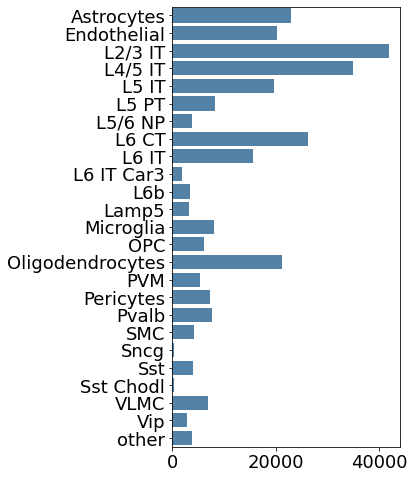

In [7]:
plt.ioff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 7))
sns.barplot(
    y=interpreter.data.celldata.obs.subclass_preprocessed.value_counts().index,
    x=list(interpreter.data.celldata.obs.subclass_preprocessed.value_counts()),
    color='steelblue',
    ax=ax
)
ax.grid(False)
#ax.set_yticks([])
plt.tight_layout()
plt.show()

0.0
1.2209650177678366
3.373137122402878
11.314344869057322
41.67061117031619
235.36600106608932
810.8033113749502
2334.0417190338585
4380.109375


/mnt/home/icb/anna.schaar/git/ncem/ncem/data.py:105: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10)


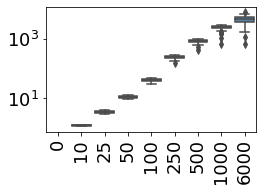

In [4]:
plt.rcParams.update({'font.size': 18})
interpreter.data.plot_degree_vs_dist(
    max_distances=[0, 10, 25, 50, 100, 250, 500, 1000, 6000 ],
    lateral_resolution=1,
)

# Figure 1: Modeling cell communication as spatial cell state dependencies.
## UMAP mouse 1 slice 153 - Fig. 1b

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


n cells:  7439


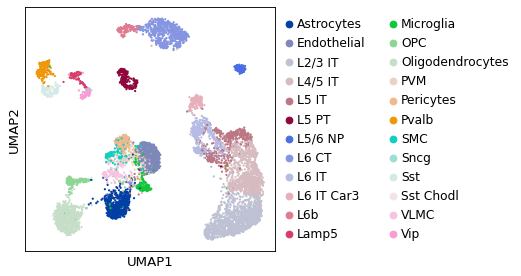

In [3]:
interpreter.data.umap(
    image_key= "mouse1_slice153",
    undefined_type='other',
    n_neighbors=10,
    n_pcs=35,
    copy=False,
    fontsize=12,
    panel_width=4,
    panel_height=4
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


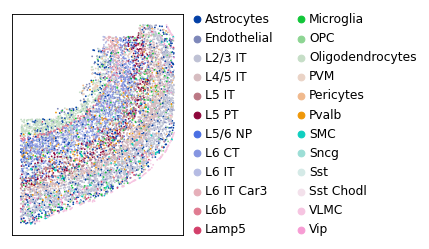

In [4]:
adata = interpreter.data.spatial(
    image_key= "mouse1_slice153",
    undefined_type='other',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True,
    copy=True
)

## Example image 488 of mouse 1 slice 153 (dataset 1 sample 3) - Fig. 1b

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


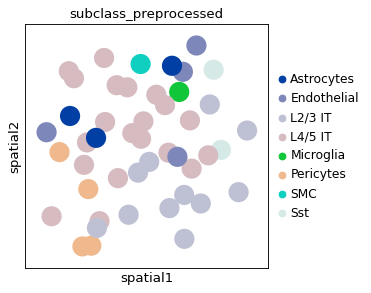

In [5]:
dataset1_sample3_486 = adata[adata.obs['fovID'] == 486]
# for hte MERFISH brain datase, coordinates are given as µm, which is transformed to pixels to match the image
dataset1_sample3_486.obsm['spatial'] = dataset1_sample3_486.obsm['spatial']/interpreter.data.celldata.uns['metadata']['lateral_resolution']
sc.pl.spatial(
    dataset1_sample3_486, 
    spot_size=200, 
    color='subclass_preprocessed', 
)

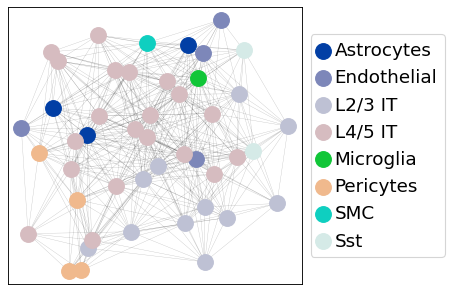

In [6]:
figsize = (6., 4.)
edge_width = 0.3

sc.set_figure_params(scanpy=True, fontsize=18)
plt.rcParams["axes.grid"] = False

h_0 = dataset1_sample3_486.obsm["node_types"]
a = dataset1_sample3_486.obsp["adjacency_matrix_connectivities"]
cell_types = dataset1_sample3_486.obs["subclass_preprocessed"]
if cell_types is None:
    raise ValueError('No cell types for this image available')
# Mask cell types like data batch:
cell_types = cell_types[np.arange(0, a.shape[0])]

cell_type_names = dataset1_sample3_486.uns['node_type_names']

g = nx.from_numpy_matrix(a.todense())
# Include masking of data batch by using h shape:
dict_nodes = {i: np.array(dataset1_sample3_486.obsm["spatial"])[i] for i in np.arange(h_0.shape[0])}

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
nx.draw_networkx_edges(
    g,
    pos=dict_nodes,
    width=edge_width,
    alpha=0.25
)

for i, ctype in enumerate(np.unique(cell_types)):
    # print(ctype)
    #color = [zeileis_28[cell_type_names[ctype]]]
    idx_c = list(np.where(cell_types == ctype)[0])
    nx.draw_networkx_nodes(
        g,
        # with_labels=False,
        node_size=200,
        nodelist=idx_c,
        node_color=dataset1_sample3_486.uns['subclass_preprocessed_colors'][i],
        pos=dict_nodes,
        label=cell_type_names[ctype].replace(
            '_', ' '
        )
    )
box = ax.get_position()
ax.invert_yaxis()
ax.set_position([box.x0, box.y0, box.width, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
# plt.savefig("dataset1_sample3_488_graph_10um.pdf")

In [ ]:
fn = f"{datadir}zhang/processed_images486.tif"
img = Image.open(fn)
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))
img.close()

images = np.array(images)
images = np.transpose(images, (1, 2, 0))

# readoutName polyT are in frames [154:160] with zPos (µm) [0.  1.5 3.  4.5 6.  7.5 9. ]
# we show the center z-plane at z=4.5µm
img = sq.im.ImageContainer(images[:, :, 157])
sq.im.process(img)
img.show('image_smooth', cmap="Greys_r", figsize=(4,4))

# Figure 2: Attributing cell heterogeneity to niche composition.
## UMAP of L2/3 IT sub-states in slice 153 - Fig. 2 a

n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


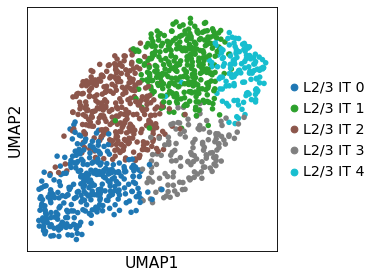

In [7]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=14,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


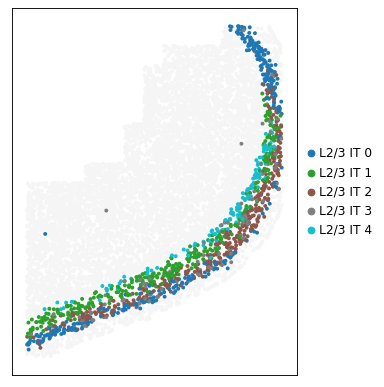

In [8]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice153",
    target_cell_type='L2/3 IT',
    panel_width=5,
    panel_height=5,
    fontsize=12,
    clean_view=True
)

## UMAPs of L2/3 IT neighbourhoods in slice 153 - Fig. 1c

In [9]:
filter_titles = [
    'Oligodendrocytes',
    'Pvalb',
    'L4/5 IT',
    'Sncg',
    'Lamp5',
    'Vip',
    'L5/6 NP',
    'VLMC',
    'L6 IT Car3',
    'Microglia',
    'Endothelial',
    'L5 IT',
    'Sst',
    'OPC',
    'Astrocytes',
    'L2/3 IT',
    'Sst Chodl',
    'Pericytes',
    'SMC',
    'PVM'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['mouse1_slice153'],
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles,
    n_neighbors=40,
    n_pcs=40
)

100%|██████████| 153/153 [01:55<00:00,  1.32it/s]


n cells:  1204
L2/3 IT 0    316
L2/3 IT 1    314
L2/3 IT 2    313
L2/3 IT 3    133
L2/3 IT 4    128
Name: L2/3 IT_substates, dtype: int64


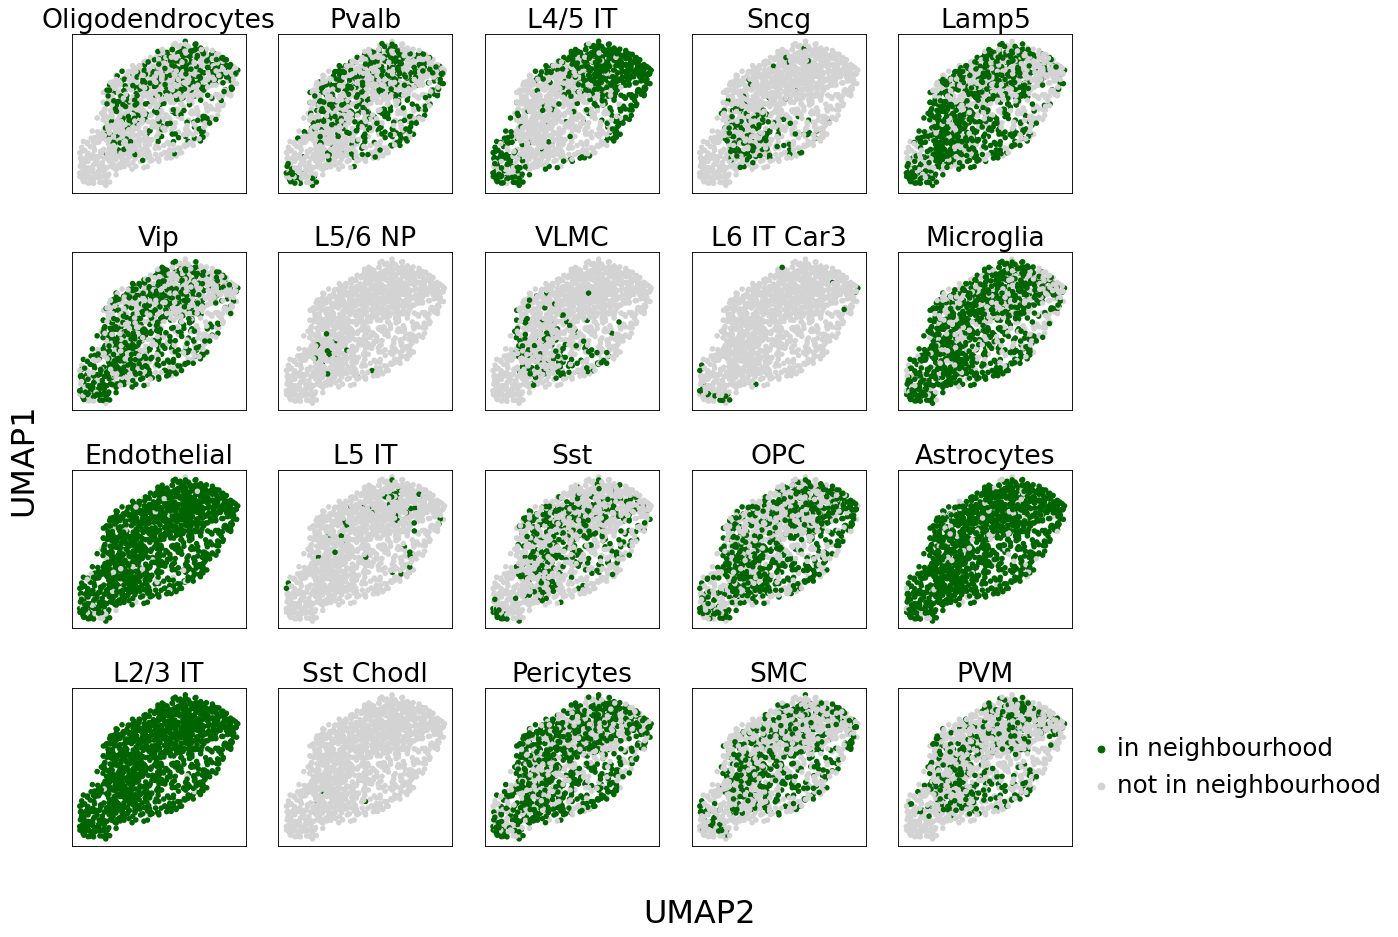

In [10]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

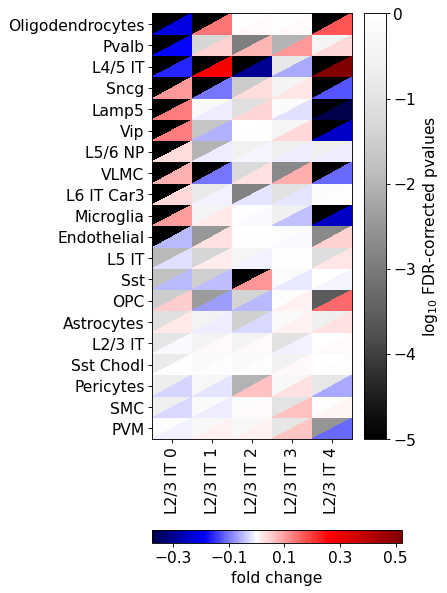

In [12]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    linspace=(-0.3, 0.5, 5)
)

# Supp. Fig. 2: Variance decomposition in spatial omics data sets.

In [13]:
var_decomp = interpreter.data.compute_variance_decomposition(undefined_type='other')

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 64/64 [03:44<00:00,  3.51s/it]


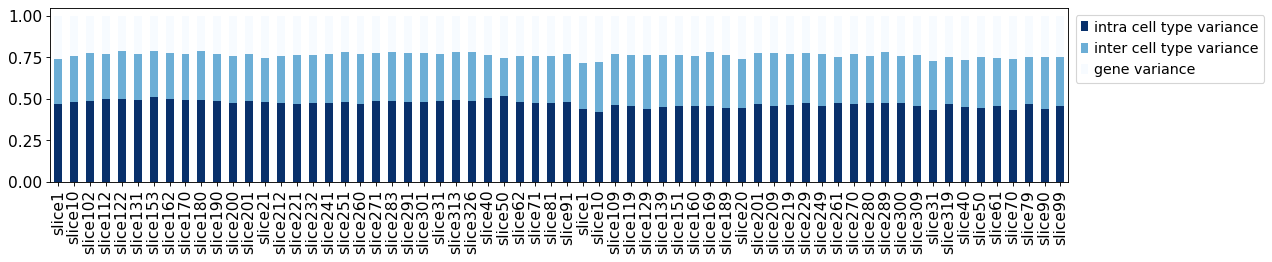

In [14]:
interpreter.data.variance_decomposition(var_decomp, multiindex=True)

In [15]:
var_decomp.mean(axis=0)[['intra cell type variance', 'inter cell type variance', 'gene variance']]

intra cell type variance    0.470461
inter cell type variance    0.292520
gene variance               0.237020
dtype: float32

# Supp. Fig. 5: Attribution of molecular states to neighborhoods in the MERFISH – brain data set.

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT_substates, dtype: int64


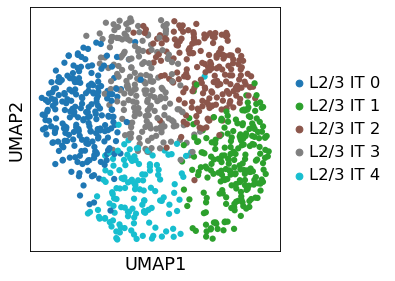

In [21]:
adata = interpreter.data.umap(
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    n_neighbors=40,
    n_pcs=40,
    fontsize=16,
    panel_width=4,
    panel_height=4,
    palette='tab10'
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


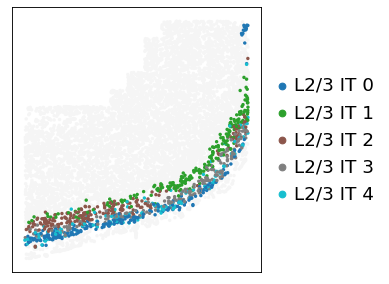

In [22]:
interpreter.data.spatial_substates(
    adata,
    image_key= "mouse1_slice162",
    target_cell_type='L2/3 IT',
    panel_width=5,
    panel_height=5,
)

In [23]:
filter_titles = ['L4/5 IT',
 'VLMC',
 'Pvalb',
 'Sncg',
 'Sst Chodl',
 'SMC',
 'Astrocytes',
 'Lamp5',
 'PVM',
 'L5 IT',
 'Oligodendrocytes',
 'L6 IT',
 'L2/3 IT',
 'Endothelial',
 'Sst',
 'OPC',
 'L6b',
 'Vip',
 'Microglia',
 'Pericytes'
]

adata, log_pval, fold_change = interpreter.data.compute_cluster_enrichment(
    image_key=['mouse1_slice162'],
    target_cell_type='L2/3 IT',
    undefined_type='other',
    clip_pvalues=-5,
    filter_titles=filter_titles
)

100%|██████████| 153/153 [01:40<00:00,  1.52it/s]


n cells:  946
L2/3 IT 0    226
L2/3 IT 1    209
L2/3 IT 2    193
L2/3 IT 3    191
L2/3 IT 4    127
Name: L2/3 IT_substates, dtype: int64


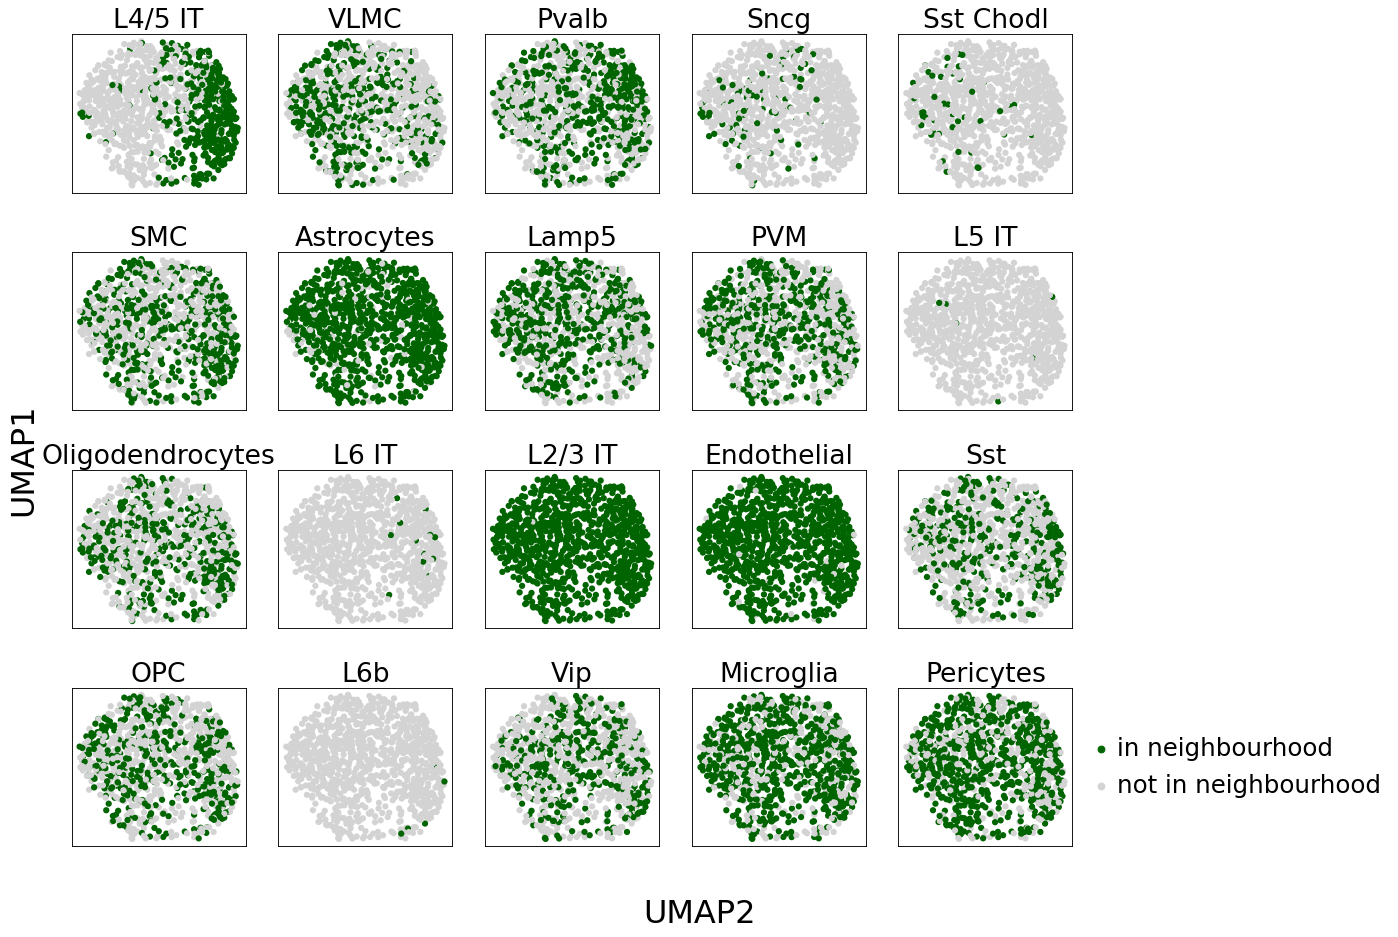

In [24]:
interpreter.data.umaps_cluster_enrichment(adata, filter_titles)

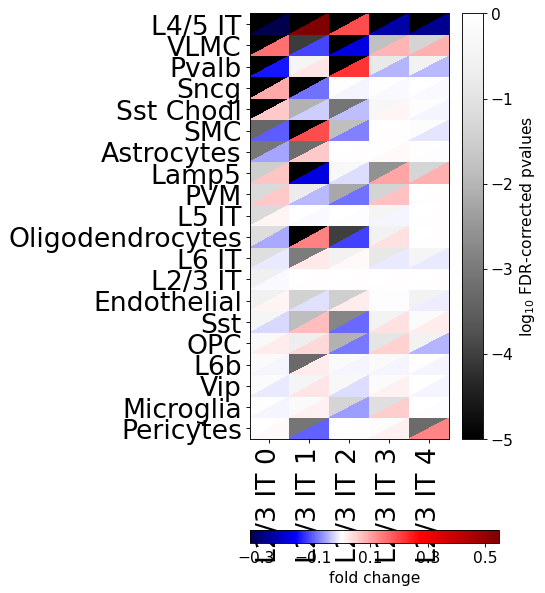

In [25]:
interpreter.data.cluster_enrichment(
    pvalues=log_pval, 
    fold_change=fold_change,
    fontsize=14,
    linspace=(-0.3, 0.5, 5)
)

# Supp. Fig. 6: Normalised contact frequencies of cell-types in spatial neighborhoods

100%|██████████| 64/64 [01:49<00:00,  1.70s/it]
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


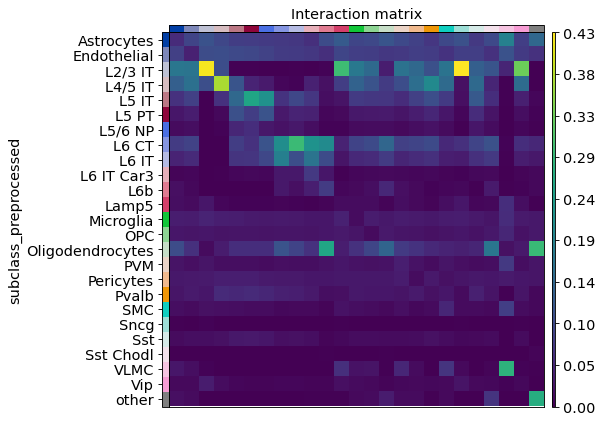

In [3]:
interpreter.data.celldata_interaction_matrix(
    figsize=(5,5),
    fontsize=13
)

# Supp. Fig. 7: Ligand–receptor permutation test.

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/omnipath/_core/requests/_utils.py:155: FutureWarning: The default value of regex will change from True to False in a future version.
  _split_unique_join(data.str.replace(r"[-\w]*:?(\d+)", r"\1")), func=func
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


n cells: 27638


  0%|          | 0/1000 [00:00<?, ?permutation/s]

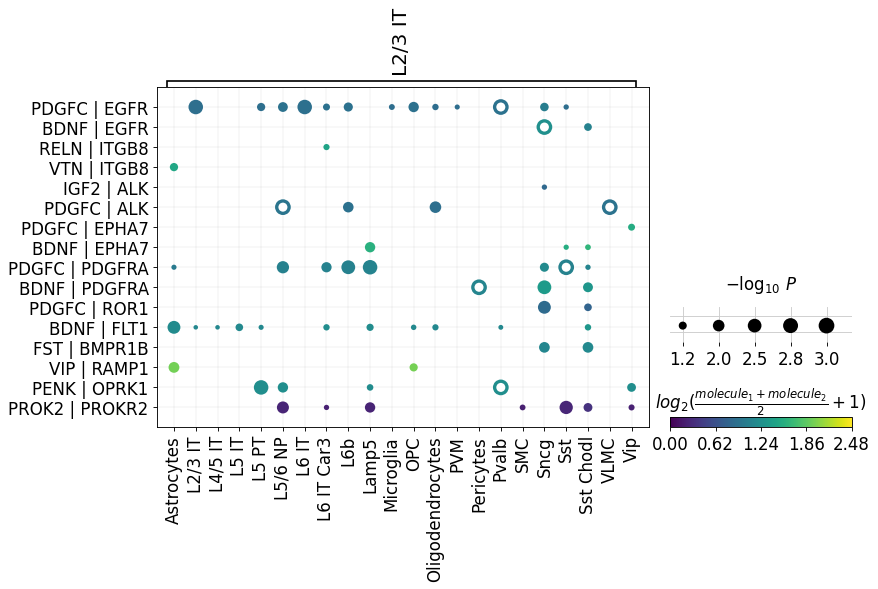

In [14]:
adata = interpreter.data.ligrec(
    fraction=0.1,
    source_groups='L2/3 IT',
    undefined_type='other',
)

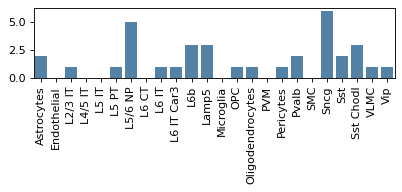

In [16]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/omnipath/_core/requests/_utils.py:155: FutureWarning: The default value of regex will change from True to False in a future version.
  _split_unique_join(data.str.replace(r"[-\w]*:?(\d+)", r"\1")), func=func
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/anna.schaar/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


n cells: 7439


  0%|          | 0/1000 [00:00<?, ?permutation/s]

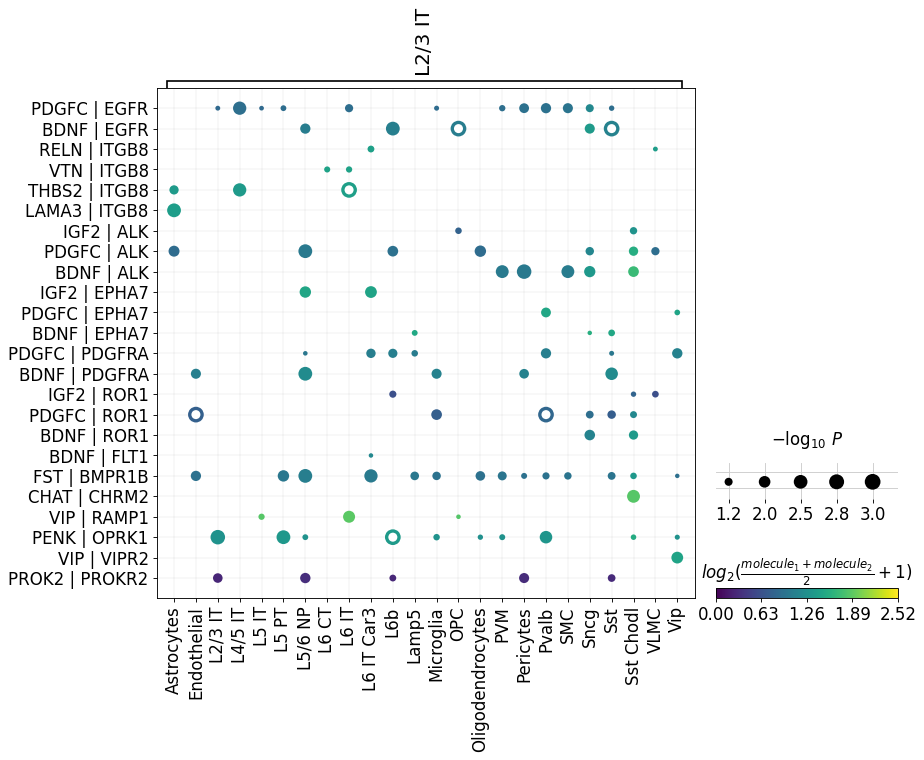

In [17]:
adata = interpreter.data.ligrec(
    image_key= "mouse1_slice153",
    source_groups='L2/3 IT',
    undefined_type='other',
)

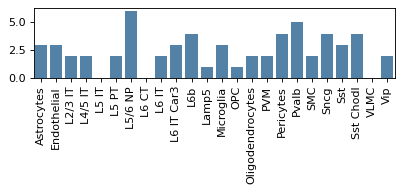

In [19]:
interpreter.data.ligrec_barplot(
    adata,
    source_group='L2/3 IT',
)

# Supp. Fig. 13: Distributional characteristics of gene expression measurements of single cells from spatial molecular profiling assays.

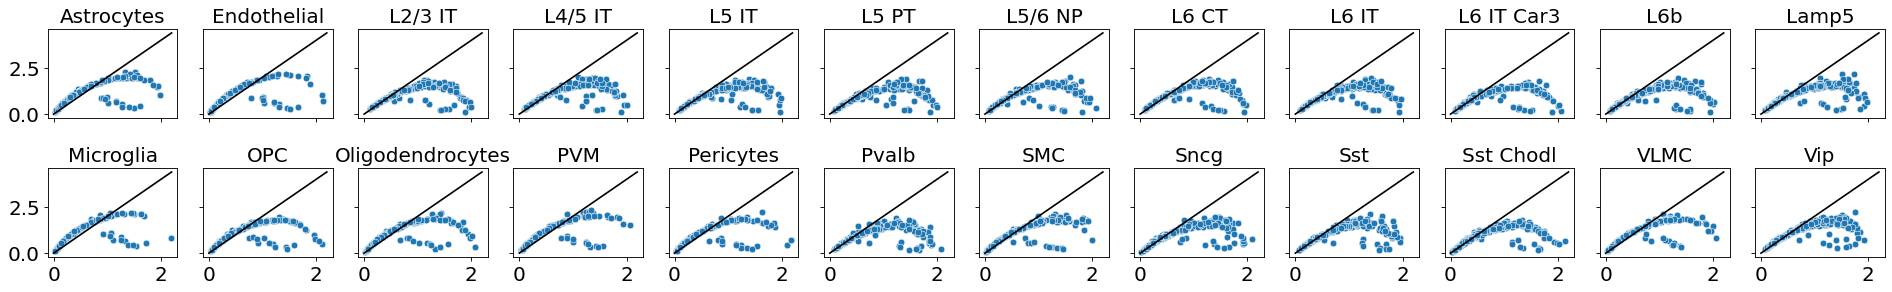

In [20]:
interpreter.data.noise_structure(undefined_type='other', min_x=0.0, max_x=2.2)